# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In [1]:
from fastai.vision import *

## Get a list of URLs

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Download Images

In [2]:
import os

In [3]:
def download_data(data_folder, folder_names):
    for folder in folder_names:  
        filename = 'urls_%s.txt'%folder 
        dest = data_folder/folder
        path_urls = data_folder/'URLs/'
        if not os.path.exists(dest): 
            print('Downloading images to %s'%dest)
            dest.mkdir(parents=True, exist_ok=True)
            download_images(path_urls/filename, dest,max_pics=200) #max_pics=500-->FAIL
        else:
            print('%s already exist!'%dest)

In [4]:
path = Path('data/flags/')
classes = ['Colombia','Ecuador','Venezuela','Armenia','France','Netherland','Paraguay','Malaysia','Liberia','USA']
download_data(path, classes)

data/flags/Colombia already exist!
data/flags/Ecuador already exist!
data/flags/Venezuela already exist!
data/flags/Armenia already exist!
data/flags/France already exist!
data/flags/Netherland already exist!
data/flags/Paraguay already exist!
data/flags/Malaysia already exist!
data/flags/Liberia already exist!
data/flags/USA already exist!


In [5]:
# %tb  #(traceback error)

You will need to run this cell once per each category.

In [6]:
path.ls()

[PosixPath('data/flags/Armenia'),
 PosixPath('data/flags/Liberia'),
 PosixPath('data/flags/France'),
 PosixPath('data/flags/URLs'),
 PosixPath('data/flags/.ipynb_checkpoints'),
 PosixPath('data/flags/Malaysia'),
 PosixPath('data/flags/USA'),
 PosixPath('data/flags/cleaned.csv'),
 PosixPath('data/flags/Ecuador'),
 PosixPath('data/flags/Paraguay'),
 PosixPath('data/flags/Venezuela'),
 PosixPath('data/flags/Netherland'),
 PosixPath('data/flags/models'),
 PosixPath('data/flags/Colombia')]

## Verify Images

In [7]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [11]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [12]:
data.classes

['Armenia',
 'Colombia',
 'Ecuador',
 'France',
 'Liberia',
 'Malaysia',
 'Netherland',
 'Paraguay',
 'USA',
 'Venezuela']

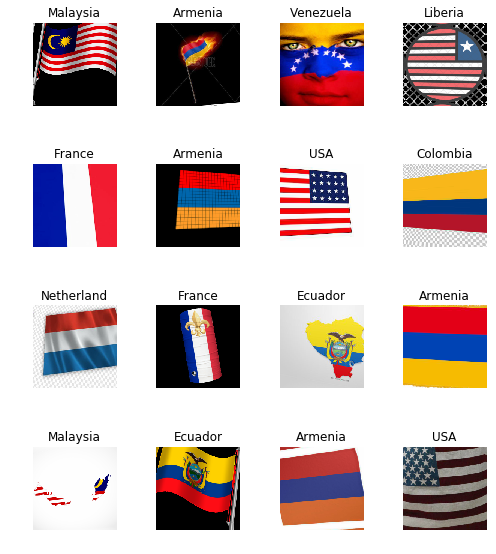

In [14]:
data.show_batch(rows=4, figsize=(7,8))

In [15]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Armenia',
  'Colombia',
  'Ecuador',
  'France',
  'Liberia',
  'Malaysia',
  'Netherland',
  'Paraguay',
  'USA',
  'Venezuela'],
 10,
 1514,
 378)

## Train model

In [16]:
# doc(cnn_learner)

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [18]:
# learn.fit_one_cycle(4)
# epoch	train_loss	valid_loss	error_rate	time
# 0	2.181186	1.242612	0.417989	00:20
# 1	1.483125	0.869580	0.293651	00:19
# 2	1.117954	0.816380	0.256614	00:18
# 3	0.915767	0.804597	0.264550	00:18

learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.242136,1.249337,0.417989,00:20
1,1.511083,0.846957,0.288360,00:20
2,1.124911,0.764145,0.238095,00:20
3,0.907849,0.757344,0.238095,00:19


In [ ]:
learn.save('flags-stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

In [ ]:
learn.save('flags-stage-2')

## Interpretation

In [ ]:
learn.load('flags-stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
# interp.plot_top_losses(9, figsize=(3,7))

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [ ]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .no_split()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

Then we create a new learner to use our new databunch with all the images.

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('flags-stage-2');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via [/tree](/tree), not [/lab](/lab). Running the `ImageCleaner` widget in Jupyter Lab is [not currently supported](https://github.com/fastai/fastai/issues/1539).

In [ ]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)


If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.


Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [ ]:
# ds, idxs = DatasetFormatter().from_similars(learn_cln)

In [ ]:
# ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Train from CLEAN-CSV

In [ ]:
# If you already cleaned your data, run this cell instead of the one before
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
# If you already cleaned your data, run this cell instead of the one before
np.random.seed(42)
data_clean = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data_clean.classes, data_clean.c, len(data_clean.train_ds), len(data_clean)

In [ ]:
learn_clean = cnn_learner(db_clean, models.resnet34, metrics=error_rate)

learn_clean.load('flags-stage-2');

In [ ]:
learn_clean.fit_one_cycle(7)

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
img = open_image(path/'black'/'00000021.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)